# Movement neural manifolds in primate S1

CEBRA with _InfoNCE loss_

**Authors**:
  * Author: steevelaquitaine@epfl.ch; laquitainesteeve@gmail.com.
  * Adapted from notebooks by Steffen Schneider, Jin H Lee, Mackenzie Mathis.  
  * Duration: 30 min

**Learning outcomes**:
  * Know how to <u>use CEBRA to compute neural manifolds</u> from the monkey's primary somatosensory cortex (S1), for variables of a reaching task.
  * Know how to set the `standard infoNCE loss`.

**Readings**:

* Schneider, S., Lee, J. H., & Mathis, M. W. (2023). Learnable latent embeddings for joint behavioural and neural analysis. Nature, 617(7960), 360-368. Shown in Fig. 3, Extended Data Fig. 8

**Python prerequisites**:

* installing and importing `libraries`
* plotting with `matplotlib` library

## (5m) Setup

1. Install `Cebra` with Python's pip software package manager (requires internet connection).
2. Import `software packages` (requires internet connection)

In [ ]:
!pip install --quiet --pre 'cebra[dev,demos]'  # install cebra software
!pip install --quiet ipython-autotime          # time track colab notebook cells
%load_ext autotime

In [ ]:
# import packages
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA

## (3s) Loading the dataset

- The data will be automatically downloaded into a `/data` folder.

In [ ]:
monkey_pos = cebra.datasets.init('area2-bump-pos-active')
monkey_target = cebra.datasets.init('area2-bump-target-active')

100%|██████████| 63.9M/63.9M [00:03<00:00, 18.0MB/s]


Download complete. Dataset saved in 'data/monkey_reaching_preload_smth_40/active_all.jl'


# Position as the auxiliary variable


In [ ]:
# @title (1s) Parametrize
# For a quick CPU run-time demo, you can drop `max_iterations` to 50-1000; otherwise set to 5000+.
max_iterations = 500

cebra_pos_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=0.0001,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [ ]:
# @title (16m) Train the model
cebra_pos_model.fit(monkey_pos.neural, monkey_pos.continuous_index.numpy())
cebra_pos = cebra_pos_model.transform(monkey_pos.neural)

pos: -0.8151 neg:  6.4292 total:  5.6141 temperature:  1.0000: 100%|██████████| 500/500 [16:25<00:00,  1.97s/it]


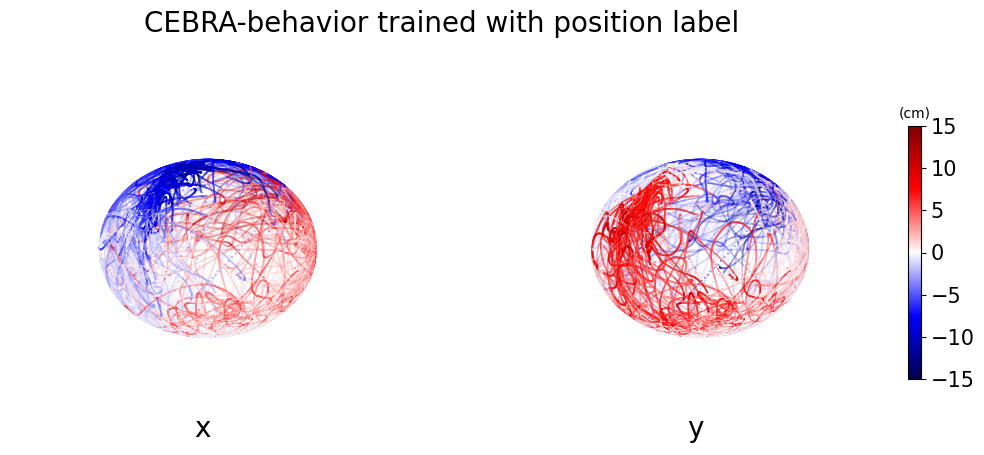

In [ ]:
# @title (1s) Plot

%matplotlib inline
fig = plt.figure(figsize=(12, 5))
plt.suptitle('CEBRA-behavior trained with position label',
             fontsize=20)
ax = plt.subplot(121, projection = '3d')
ax.set_title('x', fontsize=20, y=0)
x = ax.scatter(cebra_pos[:, 0],
               cebra_pos[:, 1],
               cebra_pos[:, 2],
               c=monkey_pos.continuous_index[:, 0],
               cmap='seismic',
               s=0.05,
               vmin=-15,
               vmax=15)
ax.axis('off')
ax = plt.subplot(122, projection = '3d')
y = ax.scatter(cebra_pos[:, 0],
               cebra_pos[:, 1],
               cebra_pos[:, 2],
               c=monkey_pos.continuous_index[:, 1],
               cmap='seismic',
               s=0.05,
               vmin=-15,
               vmax=15)
ax.axis('off')
ax.set_title('y', fontsize=20, y=0)
yc = plt.colorbar(y, fraction=0.03, pad=0.05, ticks=np.linspace(-15, 15, 7))
yc.ax.tick_params(labelsize=15)
yc.ax.set_title("(cm)", fontsize=10)
plt.show()

# TARGET as the auxiliary variable

In [ ]:
# @title (1s) Parametrize
cebra_target_model = CEBRA(model_architecture='offset10-model',
                           batch_size=512,
                           learning_rate=0.0001,
                           temperature=1,
                           output_dimension=3,
                           max_iterations=max_iterations,
                           distance='cosine',
                           conditional='time_delta',
                           device='cuda_if_available',
                           verbose=True,
                           time_offsets=10)

In [ ]:
# @title (1m) Train the model
cebra_target_model.fit(monkey_target.neural,
                       monkey_target.discrete_index.numpy())

pos: -0.7222 neg:  6.4550 total:  5.7328 temperature:  1.0000: 100%|██████████| 500/500 [00:54<00:00,  9.18it/s]


### (1s) Get its neural manifold

In [ ]:
# get its neural manifold
cebra_target = cebra_target_model.transform(monkey_target.neural)

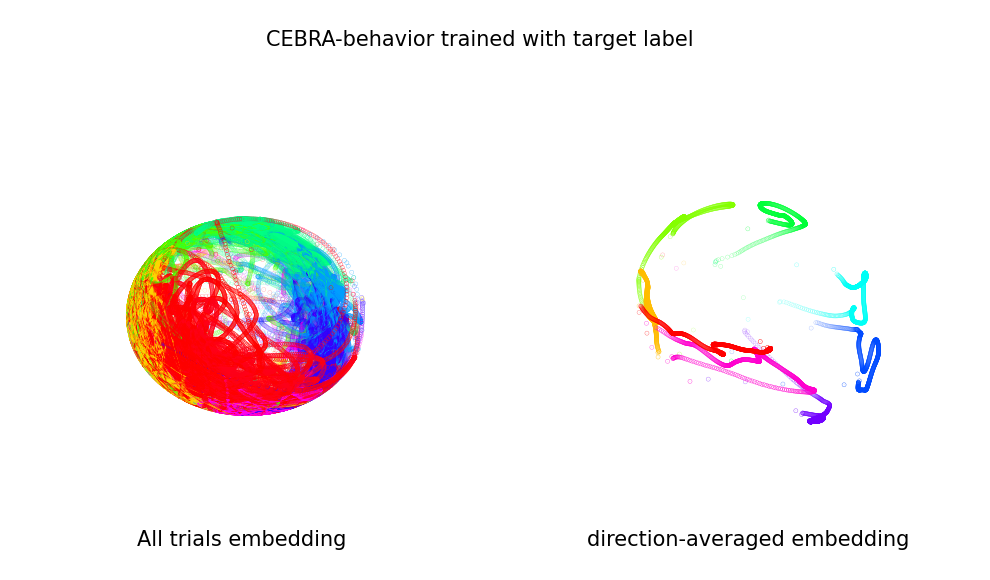

In [ ]:
# @title (1s) Plot
fig = plt.figure(figsize=(4, 2), dpi=300)
plt.suptitle('CEBRA-behavior trained with target label',
             fontsize=5)
ax = plt.subplot(121, projection = '3d')
ax.set_title('All trials embedding', fontsize=5, y=-0.1)
x = ax.scatter(cebra_target[:, 0],
               cebra_target[:, 1],
               cebra_target[:, 2],
               c=monkey_target.discrete_index,
               cmap=plt.cm.hsv,
               s=0.01)
ax.axis('off')

ax = plt.subplot(122,projection = '3d')
ax.set_title('direction-averaged embedding', fontsize=5, y=-0.1)
for i in range(8):
    direction_trial = (monkey_target.discrete_index == i)
    trial_avg = cebra_target[direction_trial, :].reshape(-1, 600,
                                                         3).mean(axis=0)
    trial_avg_normed = trial_avg/np.linalg.norm(trial_avg, axis=1)[:,None]
    ax.scatter(trial_avg_normed[:, 0],
               trial_avg_normed[:, 1],
               trial_avg_normed[:, 2],
               color=plt.cm.hsv(1 / 8 * i),
               s=0.01)
ax.axis('off')
plt.show()

# Time as the only information

In [ ]:
# @title (1s) Parametrize
cebra_time_model = CEBRA(model_architecture='offset10-model',
                         batch_size=512,
                         learning_rate=0.0003,
                         temperature=1,
                         output_dimension=3,
                         max_iterations=max_iterations,
                         distance='cosine',
                         conditional='time',
                         device='cuda_if_available',
                         verbose=True,
                         time_offsets=5)

In [ ]:
# @title (1m) Train the model
cebra_time_model.fit(monkey_target.neural)
cebra_time = cebra_time_model.transform(monkey_target.neural)

pos: -0.9906 neg:  6.4189 total:  5.4283 temperature:  1.0000: 100%|██████████| 500/500 [00:54<00:00,  9.14it/s]


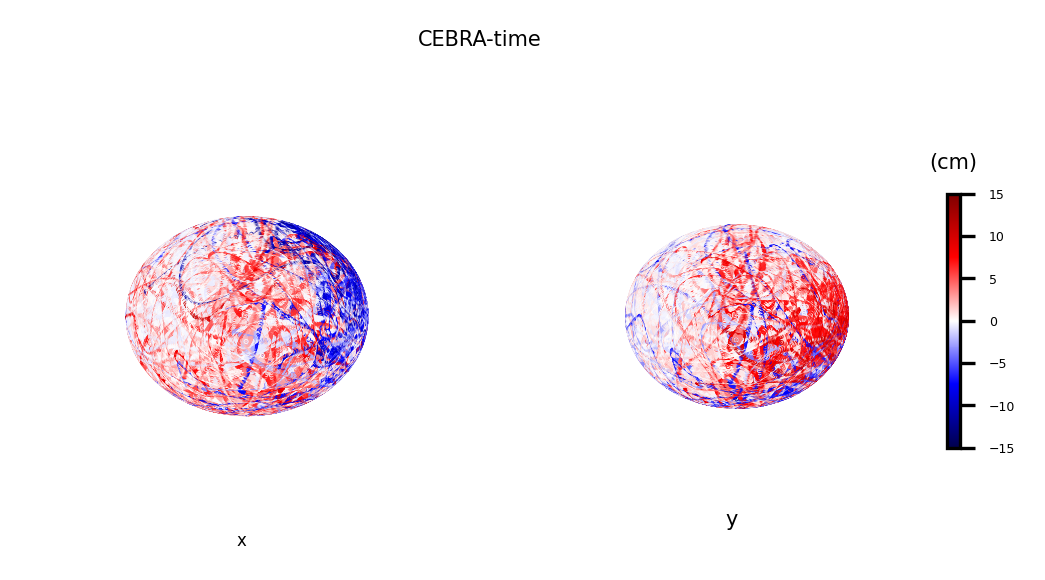

In [ ]:
# @title (1s) Plot
fig = plt.figure(figsize=(4, 2), dpi=300)
plt.suptitle('CEBRA-time', fontsize=5)
ax = plt.subplot(121, projection='3d')
ax.set_title('x', fontsize=4, y=-0.1)
x = ax.scatter(cebra_time[:, 0],
               cebra_time[:, 1],
               cebra_time[:, 2],
               c=monkey_pos.continuous_index[:, 0],
               cmap='seismic',
               s=0.05,
               vmin=-15,
               vmax=15)
ax.axis('off')
ax = plt.subplot(122, projection='3d')
y = ax.scatter(cebra_time[:, 0],
               cebra_time[:, 1],
               cebra_time[:, 2],
               c=monkey_pos.continuous_index[:, 1],
               cmap='seismic',
               s=0.05,
               vmin=-15,
               vmax=15)
ax.axis('off')
ax.set_title('y', fontsize=5, y=-0.1)
yc = plt.colorbar(y, fraction=0.03, pad=0.05, ticks=np.linspace(-15, 15, 7))
yc.ax.tick_params(labelsize=3)
yc.ax.set_title("(cm)", fontsize=5)
plt.show()